In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob
import os
import pickle

In [21]:
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
    img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img_gs = img_gs.astype(np.uint16)
    img_clahe = clahe.apply(img_gs)
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
#     img_clahe = img_clahe.astype(np.float32)
    return img_clahe

In [22]:
ds = '../input/d/bashar54h/liver-disease/cropmulti'
image_shape = (224,224)
images = []
labels = []
for directory_path in glob(ds+'/*'):
    label = directory_path.split('/')[-1]
    for img_path in glob(os.path.join(directory_path,'*.bmp')):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, image_shape)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = CLAHE(img)
        images.append(img)
        labels.append(label)

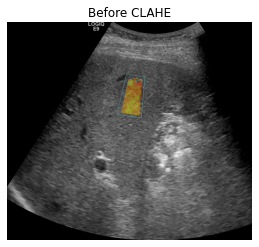

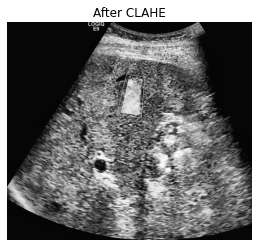

In [23]:
im = cv2.imread('../input/d/bashar54h/liver-disease/cropmulti/normal/10.bmp')
plt.axis('off')
plt.title('Before CLAHE')
plt.imshow(im)
plt.show()
plt.axis('off')
plt.title('After CLAHE')
plt.imshow(CLAHE(im))
plt.show()

In [24]:
images = np.array(images)
labels = np.array(labels)
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels,5)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.05, random_state=101, shuffle=True)

In [44]:
VGG_model = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(*image_shape, 3))
CNN_model = tf.keras.Sequential([
    VGG_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,'relu'),
    tf.keras.layers.Dense(5,'softmax')
])
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

In [45]:
# check_point = tf.keras.callbacks.ModelCheckpoint(
#     filepath='./{val_categorical_accuracy:.2f}.h5',
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=2
#     )

In [46]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [47]:
CNN_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
if os.path.exists('./') and os.path.isdir('./'):
    if os.path.exists('./l.h5'):
        model.load_weights('./l.h5')

In [48]:
history = CNN_model.fit(x_train,y_train,
                    validation_data=(x_test,y_test), 
                    epochs=50, 
                    callbacks=[ early_stop],
                    shuffle=False)

Epoch 1/50
17/17 [==============================] - 4s 219ms/step - loss: 2.7034 - categorical_accuracy: 0.4748 - val_loss: 1.2487 - val_categorical_accuracy: 0.4828
Epoch 2/50
17/17 [==============================] - 3s 205ms/step - loss: 1.2602 - categorical_accuracy: 0.5533 - val_loss: 1.1774 - val_categorical_accuracy: 0.4828
Epoch 3/50
17/17 [==============================] - 3s 205ms/step - loss: 1.1943 - categorical_accuracy: 0.5589 - val_loss: 1.2264 - val_categorical_accuracy: 0.4828
Epoch 4/50
17/17 [==============================] - 4s 206ms/step - loss: 1.1361 - categorical_accuracy: 0.6131 - val_loss: 1.1392 - val_categorical_accuracy: 0.6207
Epoch 5/50
17/17 [==============================] - 3s 206ms/step - loss: 1.0020 - categorical_accuracy: 0.6467 - val_loss: 1.0341 - val_categorical_accuracy: 0.6552
Epoch 6/50
17/17 [==============================] - 4s 206ms/step - loss: 0.9517 - categorical_accuracy: 0.6579 - val_loss: 1.0149 - val_categorical_accuracy: 0.5862
Epoc

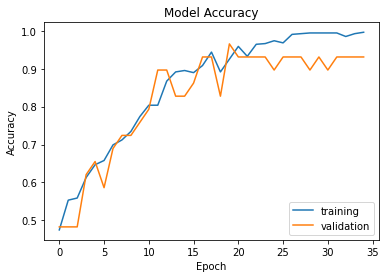

In [49]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
# plt.xticks([i for i in range(0,21)])
# plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

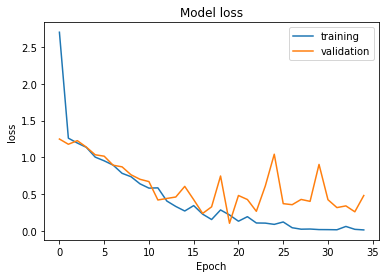

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       0.93      1.00      0.97        14

    accuracy                           0.97        29
   macro avg       0.99      0.98      0.98        29
weighted avg       0.97      0.97      0.97        29



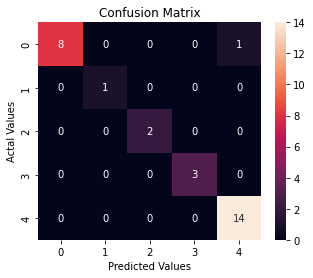

In [51]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
y_pred = CNN_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test,axis=1)
print(classification_report(y_test_, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_, y_pred), annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [52]:
CNN_model.save('CNN.h5')

In [53]:
cnn_model = tf.keras.models.load_model('CNN.h5')

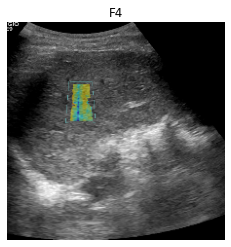

In [63]:
image_for_test = '../input/d/bashar54h/liver-disease/cropmulti/F4/26.bmp'
image_for_test = cv2.imread(image_for_test, cv2.IMREAD_COLOR)       
image_for_test = cv2.resize(image_for_test, image_shape)
plt.axis('off')
plt.imshow(image_for_test)
image_for_test = CLAHE(image_for_test)
image_for_test = tf.expand_dims(image_for_test,0)
test_label = cnn_model.predict(image_for_test)
test_label = encoder.inverse_transform(tf.argmax(test_label,axis=-1))

plt.title(test_label.item())
plt.show()